In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

In [21]:
pd.read_csv('data/data.csv').columns

Index(['Ano', 'Mes', 'Fecha', 'Precio_Bolsa', 'Aportes_GWh',
       'Volumen_Util_GWh', 'Demanda_GWh', 'ONI', 'CEN_Total', 'CEN_Hidro',
       'CEN_Termica', 'Generacion_Hidro_GWh', 'Generacion_Otros_GWh', 'IPC',
       'PRJ_0', 'PRJ_1', 'PRJ_2', 'PRJ_3', 'PRJ_4', 'PRJ_5', 'PRJ_6'],
      dtype='object')

In [8]:
def lag_time_series(serie, Pmax, remove_lag_zero=True):
    df = pd.DataFrame(serie)
    for p in range(1, Pmax+1):
        df["P_{:d}".format(p)] = serie.shift(periods = p, fill_value=0)
    if remove_lag_zero:
        df.pop(df.columns[0])
    return df 

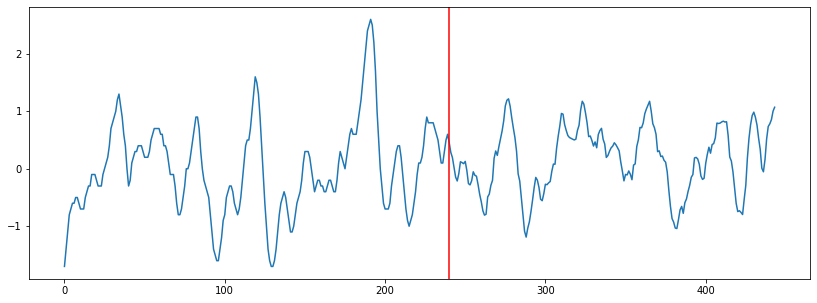

In [4]:
class ModeloONI:
    def __init__(self):
        self.ONI = pd.read_csv('data/data.csv').ONI[0:240]
        
    def build_table(self, Pmax):
        
        for p in range(1, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p)
            y = self.ONI
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)
        
            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)
            
            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            print('{:2d}  {:6.4f}  {:6.4f}'.format(p, mse_train, mse_test))
        
    
    def generate_sintetic(self, P):
        x = lag_time_series(serie=self.ONI, Pmax=P)
        m = linear_model.LinearRegression()
        m.fit(x, self.ONI)
        errors = (self.ONI - m.predict(x))[P+1:]
        errors = errors.tolist()
        y = self.ONI.tolist()
        y.extend([0] * 204)
        
        for t in range(240, len(y)):
            y[t] = m.intercept_
            for p in range(1, P+1):
                y[t] += y[t-p] * m.coef_[p-1]
            y[t] += errors[np.random.randint(0,len(errors))]
            
        return y

        
# ModeloONI().build_table(Pmax = 10)
plt.figure(figsize=(14, 5))
plt.plot(ModeloONI().generate_sintetic(P=3))
plt.axvline(x=240, c='red')

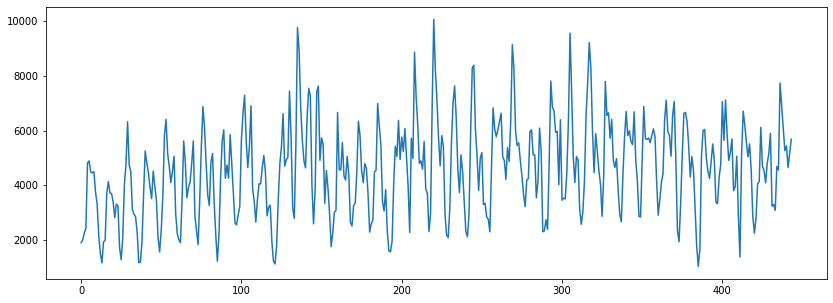

In [122]:
class ModeloAportes:
    def __init__(self):
        x = pd.read_csv("data/data.csv")
        self.ONI = x.ONI[0:240]
        self.Mes = x.Mes[0:240]
        self.Aportes = x.Aportes_GWh[0:240]
        self.dummies = x.loc[
            0:239, ["PRJ_0", "PRJ_1", "PRJ_2", "PRJ_3", "PRJ_4", "PRJ_5", "PRJ_6"]
        ]

    def remove_ONI_table(self, Pmax):
        #
        # Paso 1
        #

        for p in range(0, Pmax + 1):
            x = lag_time_series(serie=self.ONI, Pmax=p, remove_lag_zero=False)
            x = pd.concat([x, self.dummies], axis=1)
            y = self.Aportes
            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            print("{:2d}  {:6.4f}  {:6.4f}".format(p, mse_train, mse_test))

    def remove_ONI(self, p):
        #
        # Paso 2
        #
        x = lag_time_series(serie=self.ONI, Pmax=p, remove_lag_zero=False)
        x = pd.concat([x, self.dummies], axis=1)
        y = self.Aportes
        m = linear_model.LinearRegression()
        m.fit(x, y)
        self.Aportes_sin_ONI = self.Aportes - m.predict(x)

        self.model_ONI = m

        #  plt.plot(self.Aportes, color='blue')
        #  plt.plot(m.predict(x), color='black')
        #  plt.plot(self.Aportes_sin_ONI, color='k')

    def remove_seasonal_cycle(self):
        #
        # Paso 3
        #
        x = pd.concat(
            [pd.DataFrame(self.Mes), pd.DataFrame(self.Aportes_sin_ONI)], axis=1
        )
        x.columns = [x.columns[0], "Aportes_sin_ONI"]
        self.means_stds = x.groupby("Mes").agg({"Aportes_sin_ONI": [np.mean, np.std]})
        self.means_stds.columns = ["mean_mes", "std_mes"]

        self.Aportes_sin_ONI_z = [
            (v - self.means_stds["mean_mes"][t]) / self.means_stds["std_mes"][t]
            for v, t in zip(self.Aportes_sin_ONI, self.Mes)
        ]
        self.Aportes_sin_ONI_z = pd.Series(self.Aportes_sin_ONI_z)

        # plt.plot(self.Aportes_sin_ONI_z)

    def model_Aportes_sin_ONI_z_table(self, Pmax):
        #
        # Paso 4
        #
        for p in range(1, Pmax + 1):
            x = lag_time_series(
                serie=self.Aportes_sin_ONI_z, Pmax=p, remove_lag_zero=True
            )
            y = self.Aportes_sin_ONI_z

            (
                x_train,
                x_test,
                y_train_real,
                y_test_real,
            ) = train_test_split(x, y, test_size=0.4, random_state=0)

            m = linear_model.LinearRegression()
            m.fit(x_train, y_train_real)

            y_train_predict = m.predict(x_train)
            y_test_predict = m.predict(x_test)
            mse_train = metrics.mean_squared_error(y_train_real, y_train_predict)
            mse_test = metrics.mean_squared_error(y_test_real, y_test_predict)
            print("{:2d}  {:14.4f}  {:14.4f}".format(p, mse_train, mse_test))

    def generate_sintetic_Aportes_sin_ONI_z(self, P):
        x = lag_time_series(serie=self.Aportes_sin_ONI_z, Pmax=P)
        m = linear_model.LinearRegression()
        m.fit(x, self.Aportes_sin_ONI_z)
        errors = (self.Aportes_sin_ONI_z - m.predict(x))[P + 1 :]
        errors = errors.tolist()
        y = self.Aportes_sin_ONI_z.tolist()
        y.extend([0] * 204)

        for t in range(240, len(y)):
            y[t] = m.intercept_
            for p in range(1, P + 1):
                y[t] += y[t - p] * m.coef_[p - 1]
            y[t] += errors[np.random.randint(0, len(errors))]

        self.sintetic_Aportes_sin_ONI_z = y

        #  plt.plot(y)
        #  plt.axvline(x=240, c='red')
        # return y

    def generate_sintetic_Aportes_sin_ONI(self):

        x = pd.DataFrame({"z": self.sintetic_Aportes_sin_ONI_z})
        x["Mes"] = 0
        mes = 1
        for t in range(len(x.Mes)):
            x.loc[t, "Mes"] = mes
            mes = mes + 1
            mes = mes if mes <= 12 else 1

        x["Mean"] = x.Mes.map(lambda w: self.means_stds.mean_mes[w])
        x["Std"] = x.Mes.map(lambda w: self.means_stds.std_mes[w])

        x["sintetic_Aportes_sin_ONI"] = self.sintetic_Aportes_sin_ONI_z * x.Std + x.Mean

        self.sintetic_Aportes_sin_ONI = x.sintetic_Aportes_sin_ONI

        #  plt.plot(self.sintetic_Aportes_sin_ONI)
        # plt.axvline(x=240, c='red')

    def generate_sintetic_Aportes(self):

        #  sintetic_Aportes = self.sintetic_Aportes_sin_ONI
    
        sintetica_ONI = pd.Series(ModeloONI().generate_sintetic(P=3))
        
        x = lag_time_series(
            serie=sintetica_ONI, Pmax=3, remove_lag_zero=False
        )
        dummies = pd.DataFrame(
            1, columns=self.dummies.columns, index=range(240, 240 + 204)
        )
        dummies = pd.concat([self.dummies, dummies], axis = 0)
        x = pd.concat([x, dummies], axis=1)
        
        # 
        
        self.sintetic_Aportes = self.sintetic_Aportes_sin_ONI + self.model_ONI.predict(x)
        
        plt.plot(self.sintetic_Aportes)
        
        # return self.sintetic_Aportes
        # print(x)
        # print(self.model_ONI.predict(x) )
        
plt.figure(figsize=(14, 5))
#  ModeloAportes().remove_ONI_table(12)
m = ModeloAportes()
m.remove_ONI(p=3)
m.remove_seasonal_cycle()
#  m.model_Aportes_sin_ONI_z_table(Pmax=30)
m.generate_sintetic_Aportes_sin_ONI_z(14)
m.generate_sintetic_Aportes_sin_ONI()
m.generate_sintetic_Aportes()

In [78]:
pd.DataFrame(1, columns=['A', 'B'], index=['a', 'b', 'c'])

,A,B
a,1,1
b,1,1
c,1,1


In [ ]:
import matplotlib.pyplot as plt

data = pd.read_csv('data/data.csv')
plt.plot(data.ONI)